# 📝 Understanding the dataset

In [7]:
words = open('/content/names.txt').read().splitlines()

In [8]:
words[:15]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella']

In [9]:
print(f'total words :', len(words))
print(f'minimum lenght of words :', min(len(w) for w in words))
print(f'maximum lenght of words :', max(len(w) for w in words))

total words : 32033
minimum lenght of words : 2
maximum lenght of words : 15


### Creating Lookup Table

In [10]:
chars = sorted(list(set(''.join(words))))     # creating vocab of the bigram model
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [11]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

### Creating Bigram Matrix

In [12]:
import torch
BM = torch.zeros((27, 27), dtype=torch.int32)   # initializing Bigram Transition Matrix

In [13]:
for w in words:
  charList = ['.'] + list(w) + ['.']
  # print(charList)
  for ch1, ch2 in zip(charList, charList[1:]):
    idx1, idx2 = stoi[ch1], stoi[ch2]
    BM[idx1, idx2] += 1
BM = (BM+1)     # for model smoothing (add fake counts)

In [49]:
# all possible colormaps
print(*plt.colormaps(), sep='\n')   # '*' is k/a Unpacking operator; unpacks elements of list and passes them individually to print()
# print('\n'.join(plt.colormaps()))

magma
inferno
plasma
viridis
cividis
twilight
twilight_shifted
turbo
berlin
managua
vanimo
Blues
BrBG
BuGn
BuPu
CMRmap
GnBu
Greens
Greys
OrRd
Oranges
PRGn
PiYG
PuBu
PuBuGn
PuOr
PuRd
Purples
RdBu
RdGy
RdPu
RdYlBu
RdYlGn
Reds
Spectral
Wistia
YlGn
YlGnBu
YlOrBr
YlOrRd
afmhot
autumn
binary
bone
brg
bwr
cool
coolwarm
copper
cubehelix
flag
gist_earth
gist_gray
gist_heat
gist_ncar
gist_rainbow
gist_stern
gist_yarg
gnuplot
gnuplot2
gray
hot
hsv
jet
nipy_spectral
ocean
pink
prism
rainbow
seismic
spring
summer
terrain
winter
Accent
Dark2
Paired
Pastel1
Pastel2
Set1
Set2
Set3
tab10
tab20
tab20b
tab20c
grey
gist_grey
gist_yerg
Grays
magma_r
inferno_r
plasma_r
viridis_r
cividis_r
twilight_r
twilight_shifted_r
turbo_r
berlin_r
managua_r
vanimo_r
Blues_r
BrBG_r
BuGn_r
BuPu_r
CMRmap_r
GnBu_r
Greens_r
Greys_r
OrRd_r
Oranges_r
PRGn_r
PiYG_r
PuBu_r
PuBuGn_r
PuOr_r
PuRd_r
Purples_r
RdBu_r
RdGy_r
RdPu_r
RdYlBu_r
RdYlGn_r
Reds_r
Spectral_r
Wistia_r
YlGn_r
YlGnBu_r
YlOrBr_r
YlOrRd_r
afmhot_r
autumn_r
binary_

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

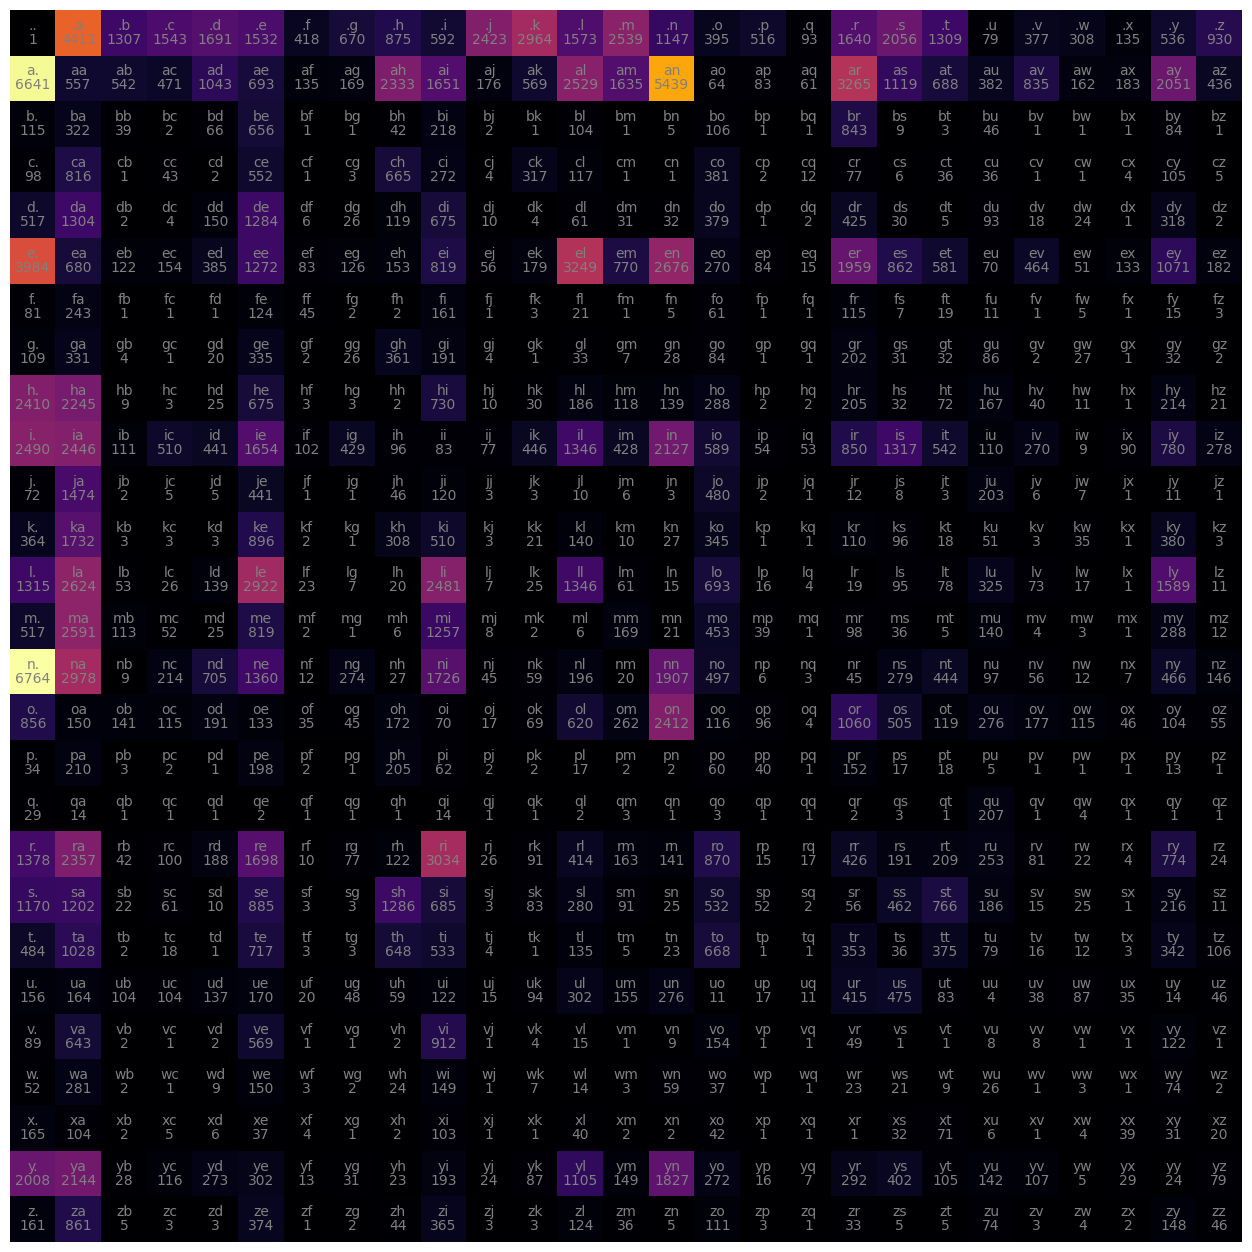

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(BM, cmap='inferno')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, BM[i, j].item(), ha="center", va="top", color='gray')  # tuple style indexing of BM for better performance
plt.axis('off')

In [15]:
P = BM.float()
P /= P.sum(1, keepdims=True)    # inplace operations are memory efficient (doesn't create extra variable or tensor(here))

# 😄 Generation of names

In [16]:
g = torch.Generator().manual_seed(8794254)

for i in range(5):
  idx = 0
  out = []
  while True:
    p = P[idx]
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[idx])
    if idx == 0:
      break
  print(''.join(out))

celyria.
eras.
zeedinia.
renleynna.
gah.


### 📉 Negative Log Likelihood Loss Function

NLL is calculated for the entire dataset for quantifying the model performance into a single number.

In [17]:
log_likelihoood = 0
n = 0

for w in words:
# for w in ['satyamqfqfz']:
  charList = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(charList, charList[1:]):
    idx1, idx2 = stoi[ch1], stoi[ch2]
    prob = P[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihoood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'log_likelihoood = {log_likelihoood}')
NLL = -log_likelihoood/n
print(f'NLL = {NLL}')   # goal is to minimize the NLL

log_likelihoood = -559951.5625
NLL = 2.4543561935424805


# 🕸️ Neural Network Approach -- The scalable approach


## Understanding the process using 1st example word

### 1. Creating Dataset

In [18]:
x, y = [], []

for w in words[:1]:
  charList = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(charList, charList[1:]):
    idx1, idx2 = stoi[ch1], stoi[ch2]
    print(ch1, ch2)
    x.append(idx1)
    y.append(idx2)

x = torch.tensor(x)     # inferes dtype automatically, unlike 'torch.Tensor()' which assigns float dtype
y = torch.tensor(y)

. e
e m
m m
m a
a .


In [19]:
x   # inputs to the NN

tensor([ 0,  5, 13, 13,  1])

In [20]:
y   # labels/outputs of the NN

tensor([ 5, 13, 13,  1,  0])

### 2. Performing one-hot encoding of the input indexes

In [21]:
import torch.nn.functional as F
x_enc = F.one_hot(x, num_classes=27).float()    # type converted so that it can take various values after @
x_enc.shape

torch.Size([5, 27])

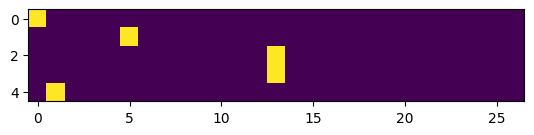

In [22]:
plt.imshow(x_enc)

### 3. Initialize the weights

In [23]:
g = torch.Generator().manual_seed(8794254)
W = torch.randn((27, 27), generator=g, requires_grad=True)    # 27 neurons (column vector) each with 27 inputs

### 4. Forward Pass (pass inputs through NN and calculate loss)

In [24]:
logits = x_enc @ W    # log-counts
counts = logits.exp()   # similar to counts, equivalent to BM    -- element wise exponentiation
probs = counts / counts.sum(1, keepdims=True)   # prob for next character
# last 2 lines are k/a 'Softmax'

In [25]:
probs.shape

torch.Size([5, 27])

In [26]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [27]:
probs[0]

tensor([0.0516, 0.0032, 0.0399, 0.0178, 0.0534, 0.0219, 0.0383, 0.0278, 0.0297,
        0.0448, 0.0733, 0.0108, 0.0430, 0.1035, 0.0010, 0.1283, 0.0142, 0.0396,
        0.0250, 0.0034, 0.0256, 0.0280, 0.0056, 0.0086, 0.0337, 0.0550, 0.0730],
       grad_fn=<SelectBackward0>)

for calculating NLL for the 1st example word, we are interested in probabilities assigned to the next char given the input char ie., prob[0, 5], prob[1, 13], prob[2, 13], prob[3, 1], prob[4, 0]

In [28]:
loss = -probs[torch.arange(5), y].log().mean()    # NLL

In [29]:
print(loss.item())

4.162745952606201


### 5. Back Pass

In [30]:
W.grad = None
loss.backward()

In [31]:
W.data -= 0.1 * W.grad

## Summarized Run for entire batch

In [32]:
# create dataset
x, y = [], []

for w in words:
  charList = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(charList, charList[1:]):    # returns zip object, which is an iterator
    idx1, idx2 = stoi[ch1], stoi[ch2]
    x.append(idx1)
    y.append(idx2)

x = torch.tensor(x)
y = torch.tensor(y)
nums = x.nelement()
print('no of elements: ', nums)

# initialize weights
g = torch.Generator().manual_seed(8794254)
W = torch.randn((27, 27), generator=g, requires_grad=True)

no of elements:  228146


In [33]:
# gradient descent
for i in range(250):

  # forward pass
  x_enc = F.one_hot(x, num_classes=27).float()
  logits = x_enc @ W    # similar to plucking rows from the W matrix
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(nums), y].log().mean() + 0.01*(W**2).mean()
  '''
  # regularization acts as model smoothing (spring force that tries to
  make the probs as close to 0 as possible (make everything
  uniform distribution), while the NLL tries to match up the prob from the data)
  '''
  # print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  W.data -= 50 * W.grad

print(loss.item())

2.4820759296417236


NOTE_1: The array W.exp() after optimization (through gradient based approach) is the same as that of the BM matrix obtained by counting the bigrams

NOTE_2 : **' x_enc @ W '** --> plucks out row of W matrix

### Sampling from NN

In [34]:
g = torch.Generator().manual_seed(8794254)

for i in range(5):
  idx = 0
  out = []

  while True:
    x_enc = F.one_hot(torch.tensor([idx]), num_classes=27).float()    # creates tensor containing the current index value
    logits = x_enc @ W    # creates weighted vector (or tensor) of logits (plucks out row of W corresponding to idx)
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)   # probabilities for next char

    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # generates index
    out.append(itos[idx])
    if idx == 0:
      break
  print(''.join(out))

celyria.
eras.
zeedinia.
renleynna.
gah.
